## Instructions
- See deadline on the course web page
- This problem set is performed individually.See examination rules on the course web page.
- Students are allowed to discuss together and help each other when solving the problems. However, every student must understand and be able to explain his/her submitted solution. Plagiarism is not allowed (submissions will be both manually and automatically monitored).
- The two notebooks for each problem set contain a number of basic and extra problems; you can choose which and how many to work on.
- Many problems are automatically graded using `assert` statements. You should check that your code passes these statements without raising an `AssertionError`. Note that there might be additional, hidden tests that must be passed for full credit. In addition, some tasks are either completely manually graded or part-automatic/part-manual.
- Note that grading is performed in the teacher's python environment, which is based on the conda `environment.yml` file in the course github repo. Please avoid using additional python modules (such as `plotly`) as this might cause automatic tests to fail.

- **Important:** Hand-in is performed through the following actions:
  - Make sure to always complete **Task 0** in the header part of the notebook. 
  - Upload your solution in the form of your edited version of this jupyter notebook via the appropriate module in Canvas.
  - The name of the uploaded file **must be the same as the original one**!
  
  Note that the hand-in might not be automatically graded if you have changed the name of the uploaded file.

- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

- Make sure that the **run time is smaller than a few minutes**. If needed you might have to reduce some computational tasks; e.g. by decreasing the number of grid points or sampling steps. Please ask the supervisors if you are uncertain about the run time. 

- Your solutions are usually expected where it says `YOUR CODE HERE` or <font color="red">"PLEASE WRITE YOUR ANSWER HERE"</font>.

### Task 0 
#### (0 points)
Fill your personal details in the dictionary 'student' with the following key/value pairs:
- **Lastname**: Your lastname as a string
- **Firstname**: Your firstname as a string
- **DOB-year**: The year for your date of birth as a four-digit integer
- **DOB-month**: The month for your date of birth as an integer (1-12)
- **DOB-day**: The year for your date of birth as an integer (1-31)
- **CID**: Your Chalmers login ID as a string

In [1]:
student={}
# Update the values below. Note the formats.
student['Lastname']='Brundin'  # string
student['Firstname']='Isak' # string
student['CID']='isakbr'        # string
student['DOB-year']=1997         # four-digit integer
student['DOB-month']=9          # integer in the range [1, 12]
student['DOB-day']=23             # integer in the range [1, 31]

# 
# YOUR CODE HERE
# 

In [2]:
for key in ['Lastname', 'Firstname','CID']:
    assert type(student[key]) is str, f'{key} is wrong type.'
    assert student[key] not in ['name_here','cid_here'],\
        f'Fill your {key} as a string.'

for key in ['DOB-year', 'DOB-month','DOB-day']:
    assert type(student[key]) is int, f'{key} is wrong type.'

assert (student['DOB-year'] > 1900 and student['DOB-year'] < 2100)
assert student['DOB-month'] in range(1,13), \
    'DOB month should be an integer in the range [1, 12]'
assert student['DOB-day'] in range(1,32), \
    'DOB day should be an integer in the range [1, 31]'

# Problem Set 1
## Extra problems
### Learning from data [TIF285], Chalmers, Fall 2021

Last revised: 29-Aug-2021 by Christian Forssén [christian.forssen@chalmers.se]

In [3]:
# import modules
import random

import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
import emcee

## Problem 5 (extra)
### (3 points)

#### Reload the third dataset from Problem 3

In [4]:
datafile = 'DataFiles/dataset3.dat'
X, y = np.loadtxt(datafile, unpack=True)
m = len(X)
X = X.reshape(m,1); y = y.reshape(m,1)

#### Validation curves
Create a validation curve for the polynomial model (for different degrees) where you plot the training score and the validation score as a function of the model complexity. 
- The model complexity is simply the degree of the polynomial.
- Make sure to print (e.g. in the axis label) what "score" that is shown (remember that there are different measures being used in the literature).
- For the computation of training and validation scores you are encouraged to use cross-validation which is more stable than the use of a single, random pair of training and validation sets.

Question to ponder:
- From this curve: Which order polynomial do you think was used when generating the data?

*Hint:* `scikit-learn` has a function `validation_curve` that might be useful. It is instructive to implement the calculation of learning curves yourself, but it is not required for this task.

In [42]:
"""
Base functions from basic problems.
"""
def design_matrix(X, degree=2):
    """
    Creates a Matrix where every column is X^[column index]
    returns X_d with shape [n x p]
    """
    m = X.shape[0]
    X_d = np.zeros((m, degree+1))
    for i in range(m):
        for j in range(degree+1):
            X_d[i,j] = X[i]**j
    return X_d

def solve_normal_equation(X_d, y):
    """
    Solves the equation theta = (XT*X)^-1*XT*Y, where X is a [n x p] matrix.
    """
    X_t = np.transpose(X_d)
    X_inv = np.linalg.inv(np.matmul(X_t,X_d))
    theta_best = np.matmul(X_inv, X_t).dot(y).flatten()
    return theta_best

def linear_regression(X, y, degree=2):
    """
    Solves normal equation where X is a [n x 1] vector.
    """
    X_mat = design_matrix(X,degree)
    theta = solve_normal_equation(X_mat,y)
    return theta

def cost_function(y,X,theta):
    """
    Cost function C(theta)=1/n sum_j=0^n-1(y_j-y-tilde_j)^2
    Rewritten on vector form as 1/n(y-X*theta)T(y-X*theta)
    """
    n = X.shape(1)
    C = 1/n*np.dot(np.transpose((y-np.dot(X,theta))),(y-np.dot(X,theta)))
    return C

def mean_squared_error(X, y, theta):
    """
    Returns Mean Squared Error for a [n x p] X-matris and [n x 1] y vector.
    """
    m = len(X)
    theta_index = np.linspace(0,len(theta)-1,len(theta))
    y_model_i = np.array([np.sum([theta[int(the)]*x_i**the for the in theta_index]) for x_i in X.reshape(m,1)])
    MSE = 1/m*np.sum((y.flatten()-y_model_i)**2)
    return MSE

def polynomial_regression( data, degree):
    """
    Returns MSE for training and validation data, also returns best fitted theta for training data.
    """
    X_t, X_v, y_t, y_v = data
    theta_t = linear_regression(X_t, y_t, degree)
    MSE_t = mean_squared_error(X_t, y_t, theta_t)
    MSE_v = mean_squared_error(X_v, y_v, theta_t)
    return MSE_t, MSE_v, theta_t


Text(0.5, 1.0, 'Validation curve for a polynomial fit')

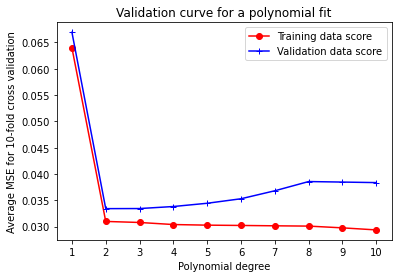

In [104]:
from sklearn.model_selection import KFold
# split the data in 10 folds to crossvalidate.
kfold = KFold(10,shuffle = True)
train_score = np.zeros(10); val_score = np.zeros(10)

degree = 10
# Perform crossvalidation for the split
for train, val in kfold.split(X):
    for i in range(degree):
        x_train = X[train]; x_val = X[val]
        y_train = y[train]; y_val = y[val]
        data = x_train, x_val, y_train, y_val
        # Calculate the mean squared error.
        MSE_t,MSE_v,_ = polynomial_regression(data, i+1)
        # Take the average of the data.
        train_score[i] += MSE_t/degree
        val_score[i] += MSE_v/degree

f = plt.figure()
degs = np.arange(1,degree+1)
my_ax = f.add_subplot(1,1,1)
my_ax.plot(degs,train_score,'ro-',label = 'Training data score')
my_ax.plot(degs,val_score,'b+-', label = 'Validation data score')
my_ax.set_xticks(degs)
my_ax.legend(loc= 'best')
my_ax.set_xlabel('Polynomial degree')
my_ax.set_ylabel('Average MSE for 10-fold cross validation')
my_ax.set_title('Validation curve for a polynomial fit')

## Problem 6 (extra)
### (3 points)

### Gradient descent methods

#### Generate noisy data with a quadratic feature
This is the same data as in Problem 2.

In [32]:
# Generate noisy data with a quadratic feature
# use the following code:
np.random.seed(42)

# X are picked uniform random [0,2]
X = 2 * np.random.rand(100, 1)
# Linear relation to the predicted value, but with Gaussian noise (mean=0, variance=1)
y = 0.5 * X**2 + X + 2 + 0.2 * np.random.randn(100, 1)

#### (a) Batch and stochastic gradient descent
Implement both batch and stochastic gradient descent and use these methods to find the best fit parameters of a quadratic model.
- You might want to tune the learning hyperparameter $\eta$.
- Do 50 epochs for the SGD (each epoch corresponding to using all instances of data once)
- Compare with the solution from Problem 2.

In [110]:

def der_cost_function(y,X_d,theta, n = len(X)):
    """
    Returns the derivative of the cost function.
    It can be analytically calculated to dC/dtheta = X_dT*(y-X_d*theta)
    Here X_d is a [n x p] Matrix
    """
    Xt = X_d.T
    dC = 2*np.matmul(Xt,(np.matmul(X_d,theta)-y))/n
    return dC

def GD(theta,y,X,eta = 0.1, n = len(X)):
    """
    Performs one iteration of gradient descent.
    Returns new parametervalues theta calculated as 
    theta_new = theta-eta*dC/dtheta
    """
    return theta - eta*der_cost_function(y,X,theta,n)


In [130]:
### Implement BGD and use it to find the best-fit parameters
#
# At the end, the following array should contain the 
# best-fit parameters: 
# theta_0 (constant term), theta_1 (linear), theta_2 (quadratic)

theta_bgd = np.array([0., 0., 0.]) # Note the order

def BGD(theta, y, X, iter = 1000, eta = 0.1):
    """
    Performs Batch Gradient Descent.
    iterates n times and performs a gradient descent on the entire vector.
    For each iteration the newly calculated theta is given as starting point for the
    next gradient descent.
    """
    X_mat = design_matrix(X)
    theta_l = list()
    theta_l.append(theta)
    for i in range(iter):
        # Perform a gradient descent for the data array.
        theta_l.append(GD(theta_l[-1].reshape(3,1),y,X_mat,eta = eta).flatten())
    return theta_l
theta_bgd_l = BGD(theta_bgd, y, X)
theta_bgd = theta_bgd_l[-1]
print(theta_bgd)


[2.1089965  0.73715854 0.61168438]


In [112]:
# Implement SGD and use it to find the best-fit parameters
#
# At the end, the following array should contain the 
# best-fit parameters: 
# theta_0 (constant term), theta_1 (linear), theta_2 (quadratic)
import random
def SGD(y,X,theta, epochs = 50, eta = 1):
    """
    Performs Stochastic Gradient Descent.
    Each data point is subject to a gradient descent, after which the data point
    is removed from the array, this is done until the array is empty and all data points
    have been subject to a gradient descent. This process is then done for 50 iterations(epochs)
    """
    theta_l = list()
    theta_l.append(theta)
    for j in range(epochs):
        # Create copies as to not mutate the original data.
        y_new = np.copy(y)
        # create a variable for the size of the entire array for the gradient.
        batch_size = len(y_new)
        X_mat = design_matrix(X)
        for i in range(batch_size):
            # take a random data point.
            randint = random.randint(0,len(y_new)-1)
            temp_y = np.array(y_new[randint])
            temp_x = X_mat[randint,:]
            # remove the datapoint from the data array.
            y_new = np.append(y_new[0:randint],y_new[randint+1:])
            X_mat = np.vstack((X_mat[0:randint,:],X_mat[randint+1:,:]))
            # perform a gradient descent for the datapoint.
            theta_l.append(GD(theta_l[-1].reshape(3,1),temp_y, temp_x.reshape(1,3),eta = eta, n=batch_size).flatten())
    return theta_l
theta_start = np.array([0., 0., 0.])
theta_sgd_l = SGD(y,X,theta_start,50,eta = 1)
theta_sgd = theta_sgd_l[-1]
print(theta_sgd)


[2.08796941 0.75717657 0.58826411]


In [55]:
assert theta_bgd.shape ==(3,)
assert not (theta_bgd==0).any()
assert theta_sgd.shape ==(3,)
assert not (theta_sgd==0).any()


#### (b) Mini-batch gradient descent
Implement mini-batch gradient descent and use this method to find the best fit parameters. Details:
- use a mini-batch size of 20%
- perform 50 epochs 
- hint: the `numpy.random.permutation` function might be useful for creating the mini-batches. 
- Compare with the solutions from BGD and SGD.

In [132]:
# Implement MBGD and use it to find the best-fit parameters
#
# At the end, the following array should contain the 
# best-fit parameters: 
# theta_0 (constant term), theta_1 (linear), theta_2 (quadratic)

def MBGD(x, y, theta, epochs=50, percentage = 20):
    """
    Performs a mini batch gradient descent.
    Creates equally large arrays given a percentage, if the data is not evenly divided by the percetage
    the last batch will just be "whatever is left".
    
    It will randomly permutate the order of the data so that all batches are random subsets of the data.
    
    The process is repeated for 50 iterations(epochs)
    """
    # Created a listed of coupled pairs.
    xy = list(zip(X, y))
    # Randomly permutate the list
    xy_mini_batch = np.random.permutation(xy)
    # recieve the two randomly permutated data arrays.
    x,y = zip(*xy)
    x = np.array(x); y = np.array(y)
    
    amount_of_batches = int(100/percentage)
    # length of each batch(the last one can differ in size)
    mini_batch_len = len(xy_mini_batch)//amount_of_batches
    theta_l = list()
    theta_l.append(theta)
    for i in range(amount_of_batches):
        # Perform a Stochastic Gradient Descent for each batch.
        theta_l.extend(SGD(y[i*20:(i+1)*min(mini_batch_len,len(x))],x[i*20:(i+1)*min(mini_batch_len,len(x))], theta_l[-1], epochs, eta = 0.2))
    return theta_l
theta_start = np.array([0., 0., 0.]) # Note the order


theta_mbgd_l = MBGD(X, y, theta_start,50)
theta_mbgd= theta_mbgd_l[-1]
print(theta_mbgd)
# 
# YOUR CODE HERE
# 

[2.07956776 0.72555508 0.67239669]


In [13]:
assert theta_mbgd.shape ==(3,)
assert not (theta_mbgd==0).any()


#### (c) Convergence
Compare the convergence pattern for the BGD, SGD and MGD, i.e. plot the path towards the optimal set of parameters. 
- Note that the path is in 3D (since there are three parameters in our quadratic model). You can plot 2D projections of the path.

1001
5001 5001 5001


Text(0.5, 1.0, 'Data and different corresponding gradient descent models ')

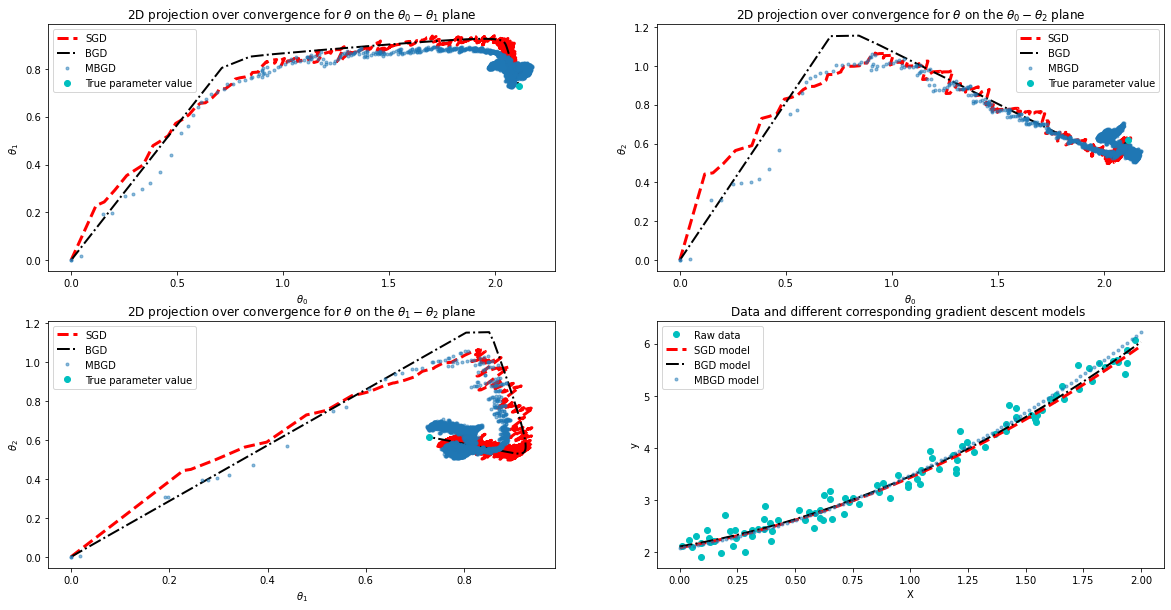

In [149]:
def get_x_y_z(theta):
    x = np.array([])
    y = np.array([])
    z = np.array([])
    for i in range(len(theta)):
        x = np.append(x,theta[i][0])
        y = np.append(y,theta[i][1])
        z = np.append(z,theta[i][2])
    return x,y,z
print(len(theta_bgd_l))
x_sgd,y_sgd,z_sgd = get_x_y_z(theta_sgd_l)
x_bgd,y_bgd,z_bgd = get_x_y_z(theta_bgd_l)
x_mbgd,y_mbgd,z_mbgd = get_x_y_z(theta_mbgd_l)
print(len(x_sgd),len(y_sgd),len(z_sgd))
fig, axs = plt.subplots(2, 2, figsize=(20,10))
x_true,y_true,z_true = 2.11228054, 0.72777588, 0.61621274
axs[0, 0].plot(x_sgd, y_sgd,'r--',linewidth = 3, label = 'SGD')
axs[0, 0].plot(x_bgd, y_bgd, 'k-.',linewidth=2, label = 'BGD')
axs[0, 0].plot(x_mbgd, y_mbgd, '.',alpha = 0.5, label = 'MBGD')
axs[0, 0].plot(x_true,y_true,'co', label = 'True parameter value')
axs[0,0].legend(loc = 'best')
axs[0, 0].set_xlabel('$\\theta_0$')
axs[0, 0].set_ylabel('$\\theta_1$')
axs[0, 0].set_title('2D projection over convergence for $\\theta$ on the $\\theta_0-\\theta_1$ plane')
axs[0,1].plot(x_sgd,z_sgd,'r--',linewidth = 3, label = 'SGD')
axs[0,1].plot(x_bgd,z_bgd,'k-.',linewidth=2, label = 'BGD')
axs[0,1].plot(x_mbgd,z_mbgd,'.',alpha = 0.5, label = 'MBGD')
axs[0, 1].plot(x_true,z_true,'co', label = 'True parameter value')
axs[0, 1].legend(loc = 'best')
axs[0, 1].set_xlabel('$\\theta_0$')
axs[0, 1].set_ylabel('$\\theta_2$')
axs[0, 1].set_title('2D projection over convergence for $\\theta$ on the $\\theta_0-\\theta_2$ plane')
axs[1,0].plot(y_sgd,z_sgd,'r--',linewidth = 3, label = 'SGD')
axs[1,0].plot(y_bgd,z_bgd,'k-.',linewidth=2, label = 'BGD')
axs[1,0].plot(y_mbgd,z_mbgd,'.',alpha = 0.5, label = 'MBGD')
axs[1, 0].plot(y_true,z_true,'co', label = 'True parameter value')
axs[1, 0].legend(loc = 'best')
axs[1, 0].set_xlabel('$\\theta_1$')
axs[1, 0].set_ylabel('$\\theta_2$')
axs[1, 0].set_title('2D projection over convergence for $\\theta$ on the $\\theta_1-\\theta_2$ plane')
axs[1,1].plot(X,y,'co', label = 'Raw data')
x = np.linspace(0,2,100)
y_sgd = theta_sgd[0]+x*theta_sgd[1]+x**2*theta_sgd[2]
axs[1,1].plot(x,y_sgd,'r--',linewidth =3, label='SGD model')
y_bgd = theta_bgd[0]+x*theta_bgd[1]+x**2*theta_bgd[2]
axs[1,1].plot(x,y_bgd,'k-.', linewidth =2, label = 'BGD model')
y_mbgd = theta_mbgd[0]+x*theta_mbgd[1]+x**2*theta_mbgd[2]
axs[1,1].plot(x,y_mbgd,'.', alpha = 0.5, label = 'MBGD model')
axs[1,1].legend(loc = 'best')
axs[1,1].set_xlabel('X')
axs[1,1].set_ylabel('y')
axs[1, 1].set_title('Data and different corresponding gradient descent models ')

